### Исходный вариант без распараллеливания

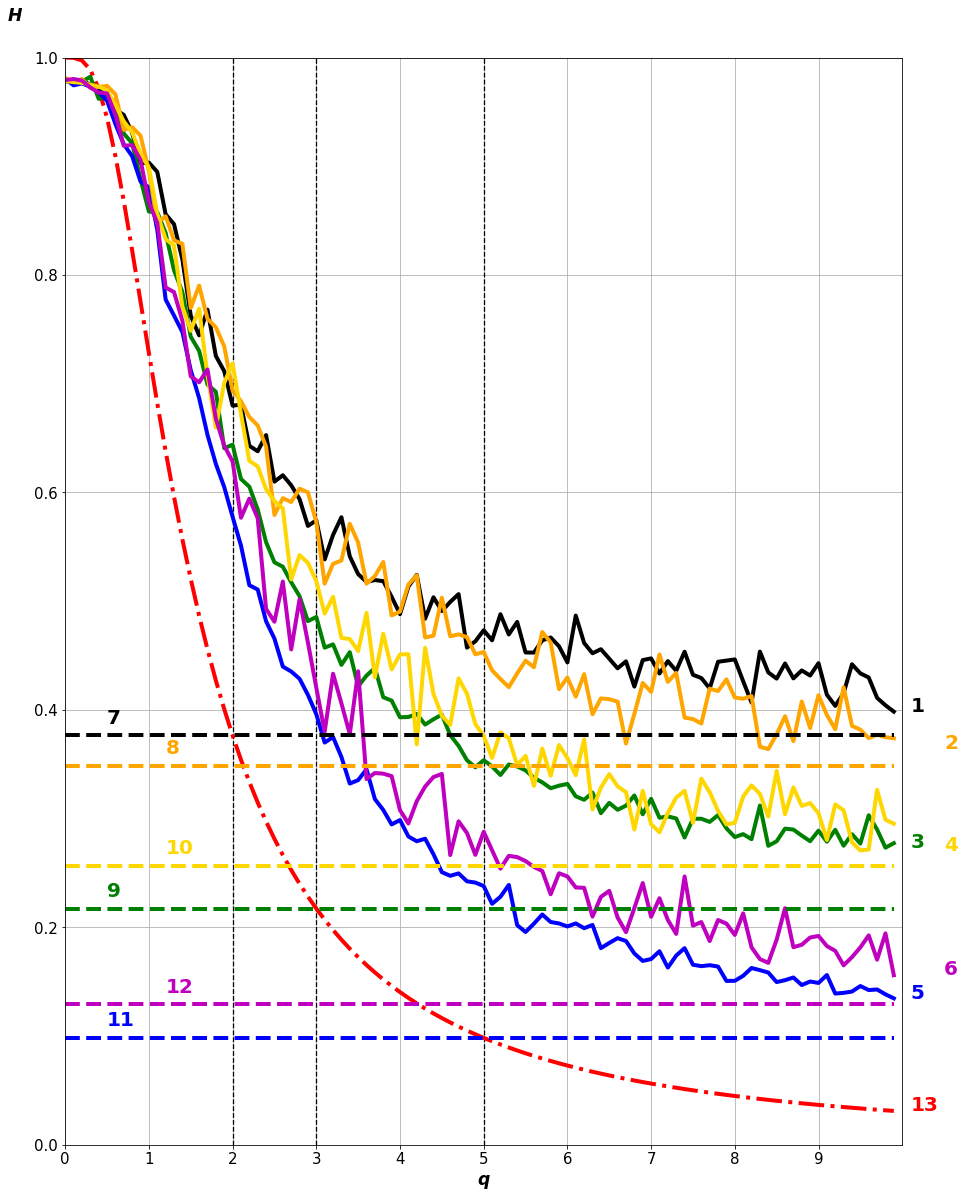

In [5]:
# рис. 7

import numpy as np
import math 
from numpy import sqrt, exp, log, pi
import random
from numpy import linalg # для собственные значения матрицы
import matplotlib.pyplot as plt
import scipy.special as sc # для гипергеометрической функции Mhyper

def D(q):
    a=150
    
    b=pi**2/3
    c=4*pi
    d=0
    for n in range(1,a+1):
        e=1/n**2
        Gamma = math.gamma(1 + n/2)
        f=(-1*q)**n
        Mhyper=sc.hyp1f1(n/2, n+1, -q**2/2)         
        m=pow(2**n, 0.5)
        g=pi*m*math.factorial(n)
        d=d + e*Gamma*f* Mhyper/g
    return b+c*d

# СКО:
q1=2; q2=3; q3=5
sigma1= sqrt(D(q1)) ; sigma2= sqrt(D(q2)); sigma3=sqrt(D(q3)) 
sigma1 = 0.5 # из рис.5

L=10
N=10
M = 10 # количество усреднений для оценки корреляционной матрицы 

# Корреляционная матрица B, распределение cos(fi)  
# - Левин 1989 стр.283 (10.1236)

def B(N, fi, iii):
    Ф1 = np.zeros((N,N), dtype=np.float64)
    for m in range(N):
        for n in range(N):
            R01 = exp(-fi**2*((m-n)/N)**2)
            Sum=0
            for r in range (L+1):
                Gamma = math.gamma(r + 3/2)
                Sum+=Gamma**2*pow(R01,(2*r+1))/(math.factorial(r)*math.factorial(r+1))          
            Ф1[m,n] = R01**2*Sum/2       
    Sum1=0
    for r in range (L+1):
        Gamma = math.gamma(r + 3/2)
        Sum1+=Gamma**2/(math.factorial(r)*math.factorial(r+1))
    Ф = Ф1/Sum1   
    Г1 = np.zeros((N,N), dtype=np.float64)
    Г1[0,0] = sqrt(Ф[0,0])    
    for i in range(N):
        for j in range(i+1):
            Sum2=0
            if j!=0:
                for p in range(j):
                    Sum2+= Г1[i,p]*np.conj(Г1[j,p])
            #чтобы не было деления на 0
            if Г1[j,j] ==0:
                Г1[j,j]=0.0000001

            Г1[i,j]=(Ф[i,j]-Sum2)/Г1[j,j]
            
            Sum3=0
            if i!=0:
                for q in range(i):
                    Sum3+= abs(Г1[i,q])**2
            c=Ф[i,i]-Sum3 
            if c<10**(-20):
                c=0
            Г1[i,i]=pow(c, 0.5)
    for i in range(N):
        for j in range(N):
            Г1[i][j]=round(Г1[i][j],3)
            Ф[i][j]=round(Ф[i][j],3)
    if iii==0: return Г1
    elif iii==1: return Ф
    
#возвращает Массив случайных комплексных чисел <class 'numpy.ndarray'>
def rnorm(N,mu,sigma):
    arr = np.array([])
    for i in range(N):
        a=random.gauss(mu, sigma)
        b=random.gauss(mu, sigma)
        arr = np.append(arr , complex(a,b))
    return arr

def rnorm_1(N,mu,sigma):
    arr = np.array([])
    for i in range(N):
        a=random.gauss(mu, sigma)
        arr = np.append(arr , a)
    return arr

# Энтропия: детерминированный сигнал со случайной фазой + собственный шум
# fi - это СКО фазы
def H1(A,f, fi):
    R = np.zeros((M*N,N,N),dtype=np.complex128) # Корреляционная матрица пришедшего сигнала
    for i in range(N*M):
        S0 = np.array([])
        Noise =  rnorm(N,0,1)
        fi0 = rnorm_1(N,0, fi)
        for k in range(N):
            S0 = np.append(S0 , Noise[k]+A*exp(1j*(2*math.pi*f*k/N + fi0[k])))
        #транспонированная матрица
        S=np.array([S0]).T
        #комплексно-сопряженная матрица
        S_h= np.conj(S0)
        R[i]=S*S_h 
    RRR  = np.zeros((N,N),dtype=np.complex128)
    for i in range(N*M):
        RRR=RRR+R[i]
    RRR  = RRR/(N*M)
    #собственные значения матрицы RRR
    L=linalg.eig(RRR)[0] 
    EV=L
    sum_EV=0
    for i in range(N): sum_EV+=abs(EV[i])
    AN=EV/sum_EV
    E=0
    for i in range(N): E+= - abs(AN[i])*math.log(abs(AN[i]))
    return E

def H1_gr(A,f, fi):
    gr=[]
    for i in range(len(A)): 
        gr.append(H1(A[i], f, fi))
    return gr

def H2(A, fi):
    G=np.array(B(N,fi,0))
    R = np.zeros((M*N,N,N),dtype=np.complex128)#Корреляционная матрица пришедшего сигнала
    for i in range(N*M):
        S0 = np.array([])
        Noise =  rnorm(N,0,1)
        c=np.array(rnorm(N,0,1))
        ASHP= G.dot(c) # умножение матрицы G на матрицу c
        for k in range(N):
            S0 = np.append(S0 , Noise[k]+(A*ASHP[k]))
        #транспонированная матрица
        S=np.array([S0]).T
        #комплексно-сопряженная матрица
        S_h= np.conj(S0)
        R[i]=S*S_h 
    RRR  = np.zeros((N,N),dtype=np.complex128)
    for i in range(N*M):
        RRR=RRR+R[i]
    RRR  = RRR/(N*M) 
    #собственные значения матрицы RRR
    EV=linalg.eig(RRR)[0]
    sum_EV=0
    for i in range(N): sum_EV += EV[i]
    AN=EV/abs(sum_EV)
    E=0
    for i in range(N): E += - abs(AN[i])*math.log(abs(AN[i]))
    return E

def H2_gr(A,fi):
    gr=[]
    for i in range(len(A)): 
        gr.append(H2(A[i],fi))
    return gr

def E(A, fi):
    S0=B(N,fi,1)
    EV=linalg.eig(S0)[0]
    sum_EV=0
    for i in range(N): sum_EV += abs(EV[i])
    AN=EV/sum_EV
    E=0
    for i in range(N): E += - abs(AN[i])*math.log(abs(AN[i]))
    return E

def E_gr(A, fi):
    gr=[]
    for i in range(len(A)): 
        gr.append(E(A[i],fi))
    return gr

def H(q,N):
    return(math.log(q**2 *N + N) - (q**2*N+1)*math.log(q**2*N+1)/(q**2 *N + N))

def H_gr(q,N):
    gr=[]
    for i in range(len(q)): 
        gr.append(H(q[i],N))
    return gr

def J(A, A0): return H(A0, N)

def J_gr(A,A0):
    gr=[]
    for i in range(len(A)): 
        gr.append(J(A[i],A0))
    return gr

A = np.arange(0,10,0.1)
f=0

labels=['1','3','5','2', '4', '6', '7', '9','11', '8', '10', '12']
colors=['black', 'green', 'blue', 'orange', "gold", 'm','black', 'green', "blue", 
        'orange', 'gold', 'm']

sigmas_H = [sigma1, sigma2 ,sigma3] # СКО фазы
qs = [q1, q2, q3]
sigmas_E = [sigma1, sigma2 ,sigma3]
fig, ax = plt.subplots()

gr=H_gr(A, N)
gr=gr/log(N)
ax.plot(A, gr, 'red', linestyle='-.', label='13', linewidth=4 )
plt.axis([0,10,0,1])
xmin, xmax, ymin, ymax = plt.axis()
plt.text(xmax+0.1, min(gr), '13', color = 'red' , fontsize = 20, fontweight='bold')
    
for i in range(len(sigmas_H)):
    gr=H1_gr(A,f, sigmas_H[i])
    gr=gr/log(N)
    ax.plot(A, gr, colors[i], label=labels[i] , linewidth=4)
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.1, min(gr), labels[i], color =colors[i] , fontsize = 20, fontweight='bold')

for i in range(len(sigmas_H)):
    gr=H2_gr(A, sigmas_H[i])
    gr=gr/log(N)
    ax.plot(A, gr, colors[i+3], label=labels[i+3] , linewidth=4)
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.5, min(gr), labels[i+3], color =colors[i+3] , fontsize = 20, fontweight='bold')

for i in range(len(qs)):
    gr=J_gr(A, qs[i])
    gr=gr/log(N)
    ax.plot(A, gr, colors[i+6], label=labels[i+6], linestyle = '--' , linewidth=4)
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmin+0.5, min(gr)+0.011, labels[i+6], color =colors[i+6] , fontsize = 20, fontweight='bold')

for i in range(len(sigmas_E)):
    gr=E_gr(A, sigmas_E[i])
    gr=gr/log(N)
    ax.plot(A, gr, colors[i+9], label=labels[i+9], linestyle = '--', linewidth=4 )
    plt.axis([0,10,0,1])
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmin+1.2, min(gr)+0.011, labels[i+9], color =colors[i+9] , fontsize = 20, fontweight='bold')

xxs=[2,3,5]
for i in range(3):
    plt.vlines(x=xxs[i], ymin=ymin, ymax=ymax, colors = 'black', linestyles='dashed', linewidths=1.3)
    
plt.xlabel('q', color='black',fontsize = 'xx-large', style = 'italic', weight=600, loc='center')
plt.ylabel('H', color='black',fontsize = 'xx-large',style = 'italic', weight=600 , rotation=0, y=1.03, labelpad=20)

# изменяем шаг по оси x 
plt.axis([0,10,0,1])
xmin, xmax, ymin, ymax = plt.axis()
step=(xmax-xmin)/10
plt.xticks(np.arange(xmin, xmax, step))
plt.axis([xmin, xmax, ymin, ymax])


plt.tick_params(labelsize = 15)
#plt.legend(loc = 'upper right', fontsize = 15)
plt.rcParams["figure.figsize"] = (15, 20) 
plt.grid(True)
plt.show()


### Исходный вариант с распараллеливанием

Не делала, 

### TkInter без распараллеливания

### TkInter с распараллеливанием